# Logistic Regression

## Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report

scikit-learn version: 0.22.1


In [4]:
def plot_data(x, y):
    """Plot some 2D data"""

    fig, ax = plt.subplots()
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
    ax.add_artist(legend1)
    plt.xlim((min(x[:, 0]) - 0.1, max(x[:, 0]) + 0.1))
    plt.ylim((min(x[:, 1]) - 0.1, max(x[:, 1]) + 0.1))


def plot_decision_boundary(pred_func, x, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
    plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)

## Binary classification

### Problem formulation

Logistic regression is a classification algorithm used to estimate the probability that a data sample belongs to a particular class.

A logistic regression model computes a weighted sum of the input features (plus a bias term), then applies the [logistic function](activations:sigmoid) to this sum in order to output a probability.

$$y' = \mathcal{h}_\theta(\pmb{x}) = \sigma(\pmb{\theta}^T\pmb{x})$$

The function output is thresholded to form the model's prediction:

- $0$ if $y' \lt 0.5$
- $1$ if $y' \geqslant 0.5$

### Loss function: Binary Crossentropy (log loss)

See [loss definition](loss:bce) for details.

### Model training

- No analytical solution because of the non-linear $\sigma()$ function: gradient descent is the only option.
- Since the loss function is convex, GD (with the right hyperparameters) is guaranteed to find the global loss minimum.
- Different GD optimizers exist: *newton-cg*, *l-bfgs*, *sag*... *Stochastic gradient descent* is another possibility, efficient for large numbers of samples and features.

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\boldsymbol{\theta})
     \end{pmatrix} = \frac{2}{m}\pmb{X}^T\left(\sigma(\pmb{X}\pmb{\theta}) - \pmb{y}\right)$$

### Example: classify planar data

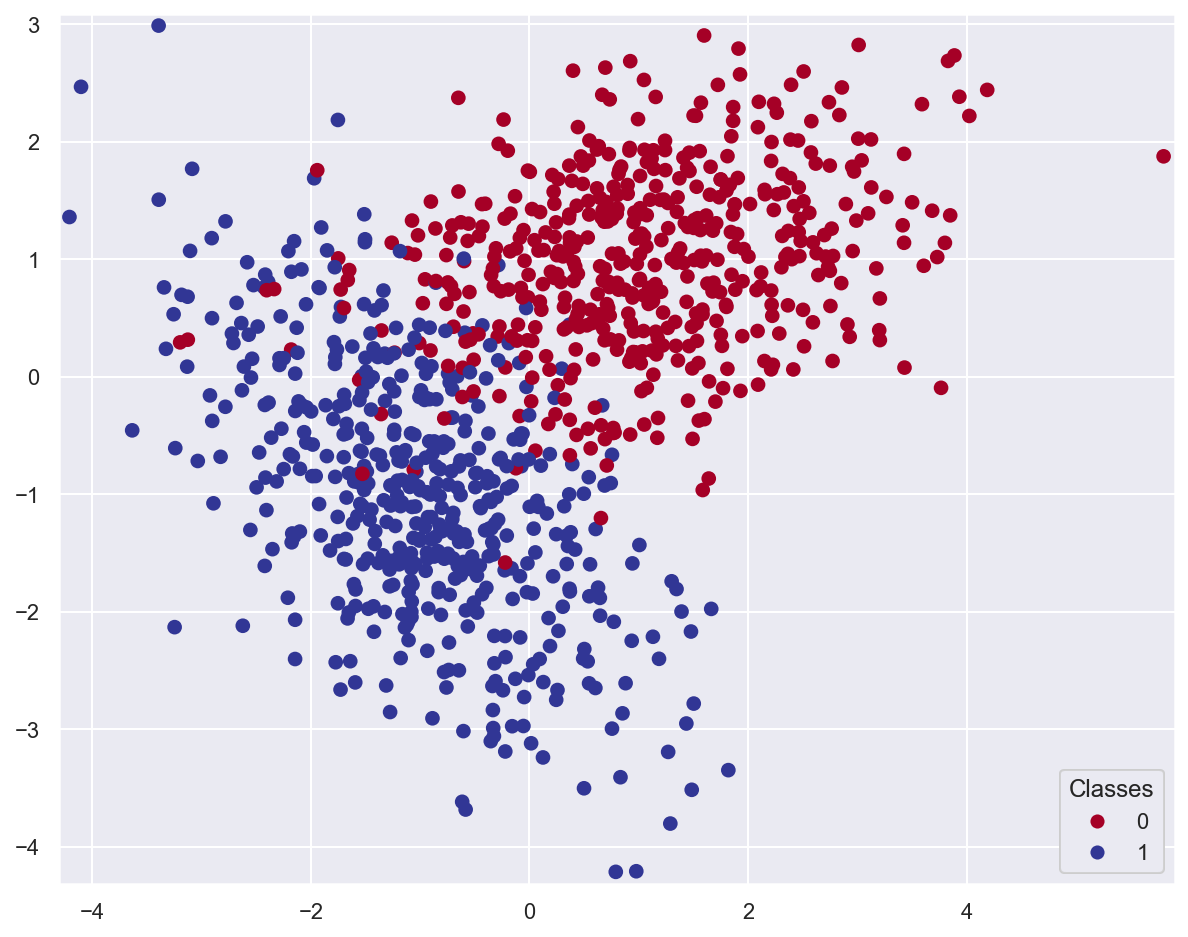

In [5]:
# Generate 2 classes of linearly separable data
x_train, y_train = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=26,
    n_clusters_per_class=1,
)
plot_data(x_train, y_train)

In [6]:
# Create a Logistic Regression model based on stochastic gradient descent
# Alternative: using the LogisticRegression class which implements many GD optimizers
lr_model = SGDClassifier(loss="log")

# Train the model
lr_model.fit(x_train, y_train)

print(f"Model weights: {lr_model.coef_}, bias: {lr_model.intercept_}")

Model weights: [[-2.96719034 -2.55668143]], bias: [-0.57585284]


In [7]:
# Print report with classification metrics
print(classification_report(y_train, lr_model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       502
           1       0.92      0.96      0.94       498

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



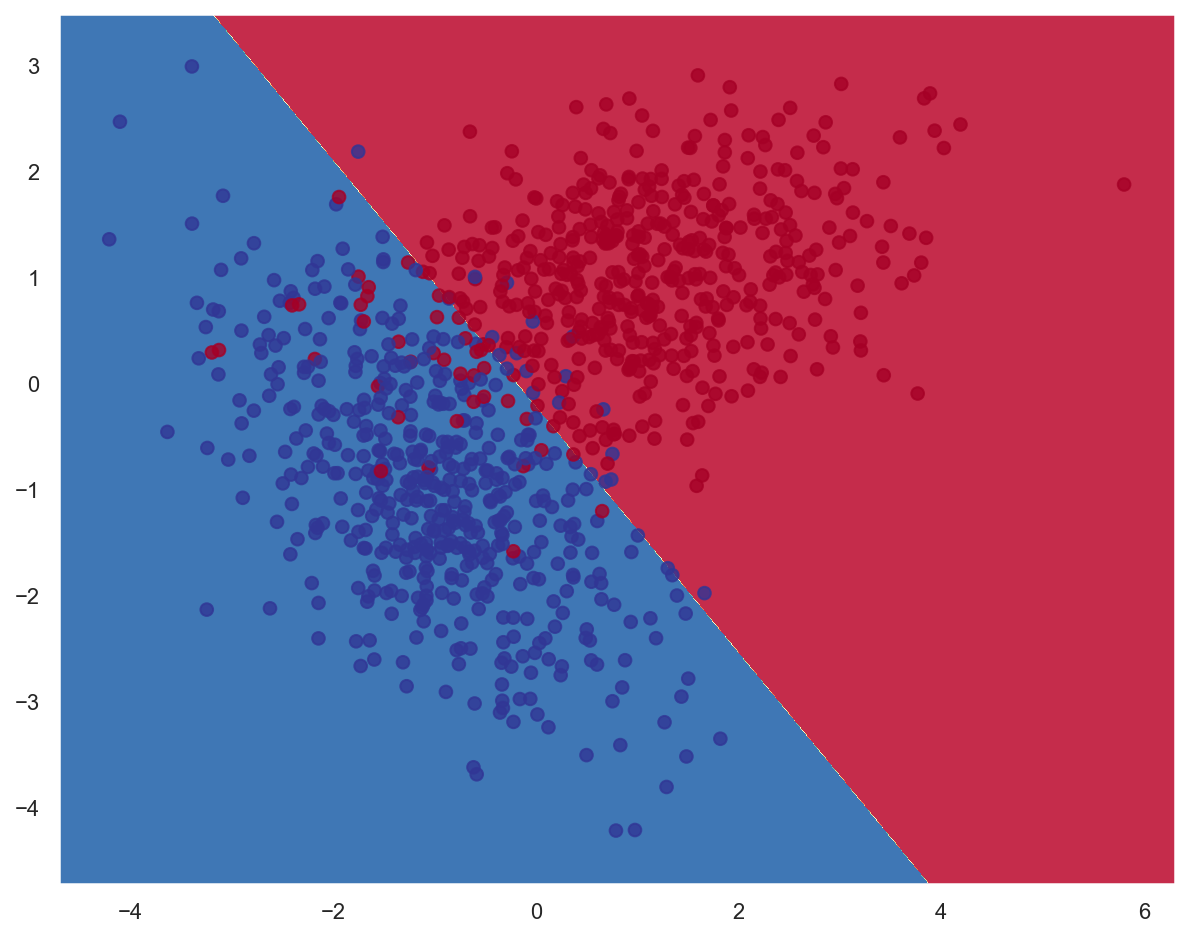

In [8]:
# Plot decision boundary
plot_decision_boundary(lambda x: lr_model.predict(x), x_train, y_train)

## Multivariate regression

### Problem formulation

**Multivariate regression**, also called *softmax regression*, is a generalization of logistic regression for multiclass classification.

A softmax regression model computes the scores $s_k(\pmb{x})$ for each class $k$, then estimates probabilities for each class by applying the [softmax](activations:softmax) function to compute a probability distribution.

For a sample $\pmb{x}^{(i)}$, the model predicts the class $k$ that has the highest probability.

$$s_k(\pmb{x}) = {\pmb{\theta}^{(k)}}^T\pmb{x}$$

$$\mathrm{prediction} = \underset{k}{\mathrm{argmax}}\;\sigma(s(\pmb{x}^{(i)}))_k$$

Each class $k$ has its own parameter vector $\pmb{\theta}^{(k)}$.

### Model output

- $\pmb{y}^{(i)}$ (*ground truth*): **binary vector** of $K$ values. $y^{(i)}_k$ is equal to 1 if the $i$th sample's class corresponds to $k$, 0 otherwise.
- $\pmb{y}'^{(i)}$: **probability vector** of $K$ values, computed by the model. $y'^{(i)}_k$ represents the probability that the $i$th sample belongs to class $k$.

$$\pmb{y}^{(i)} = \begin{pmatrix}
       \ y^{(i)}_1 \\
       \ y^{(i)}_2 \\
       \ \vdots \\
       \ y^{(i)}_K
     \end{pmatrix} \in \pmb{R}^K\;\;\;\;
\pmb{y}'^{(i)} = \begin{pmatrix}
       \ y'^{(i)}_1 \\
       \ y'^{(i)}_2 \\
       \ \vdots \\
       \ y'^{(i)}_K
     \end{pmatrix} = \begin{pmatrix}
       \ \sigma(s(\pmb{x}^{(i)}))_1 \\
       \ \sigma(s(\pmb{x}^{(i)}))_2 \\
       \ \vdots \\
       \ \sigma(s(\pmb{x}^{(i)}))_K
     \end{pmatrix} \in \pmb{R}^K$$

### Loss function: Categorical Crossentropy

See [loss definition](loss:cce) for details.

### Model training

Via gradient descent:

$$\nabla_{\theta^{(k)}}\mathcal{L}(\pmb{\theta}) = \frac{1}{m}\sum_{i=1}^m \left(y'^{(i)}_k - y^{(i)}_k \right)\pmb{x}^{(i)}$$

$$\pmb{\theta}^{(k)}_{next} = \pmb{\theta}^{(k)} - \eta\nabla_{\theta^{(k)}}\mathcal{L}(\pmb{\theta})$$

### Example: classify multiclass planar data

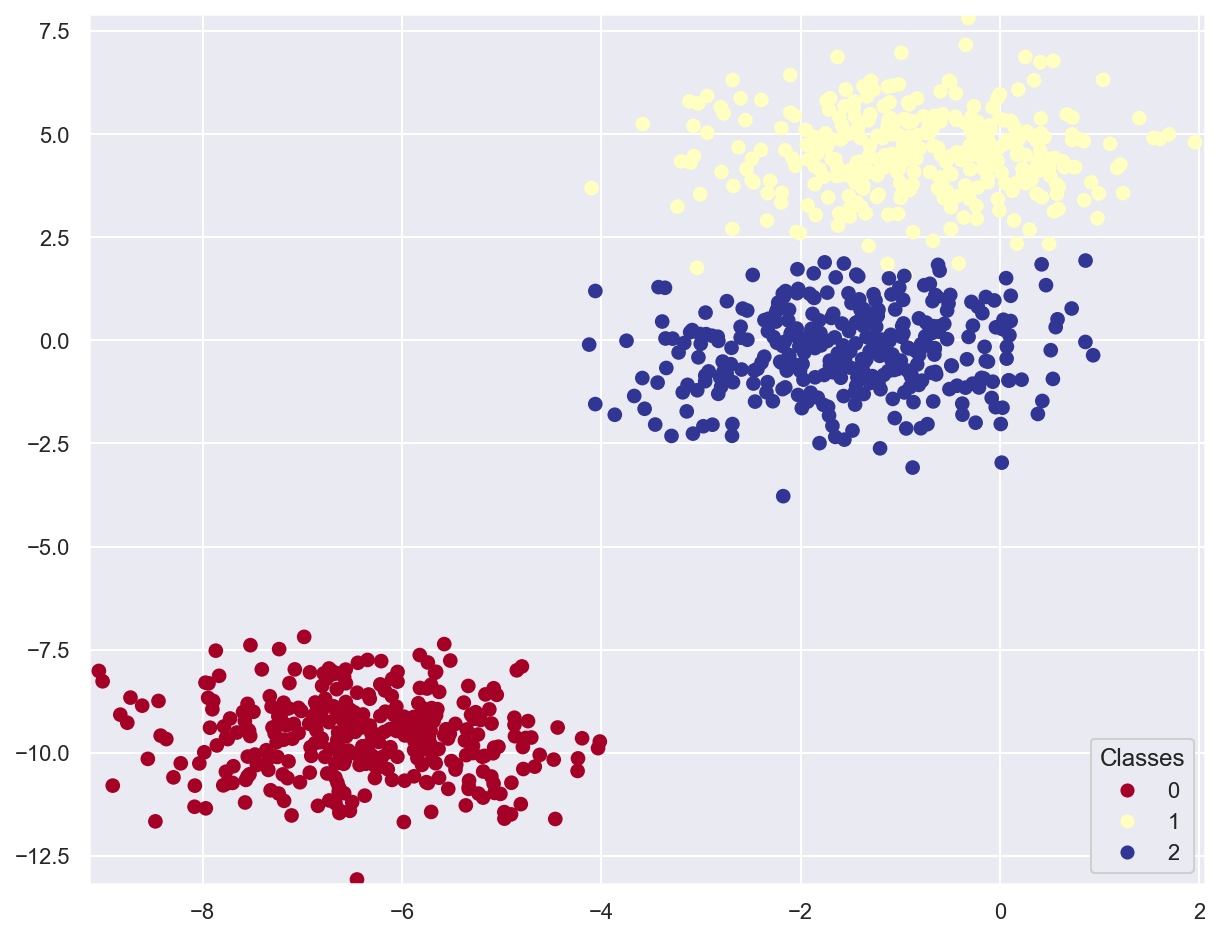

In [9]:
# Generate 3 classes of linearly separable data
x_train_multi, y_train_multi = make_blobs(n_samples=1000, n_features=2, centers=3, random_state=11)

plot_data(x_train_multi, y_train_multi)

In [10]:
# Create a Logistic Regression model based on stochastic gradient descent
# Alternative: using LogisticRegression(multi_class="multinomial") which implements SR
lr_model_multi = SGDClassifier(loss="log")

# Train the model
lr_model_multi.fit(x_train_multi, y_train_multi)

print(f"Model weights: {lr_model_multi.coef_}, bias: {lr_model_multi.intercept_}")

Model weights: [[ -5.76624648 -17.43149458]
 [ -1.27339599  19.17812979]
 [  1.5231193   -0.91647832]], bias: [-133.15588019  -38.36388245    2.53712564]


In [11]:
# Print report with classification metrics
print(classification_report(y_train_multi, lr_model_multi.predict(x_train_multi)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       334
           1       0.99      0.99      0.99       333
           2       0.99      0.99      0.99       333

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



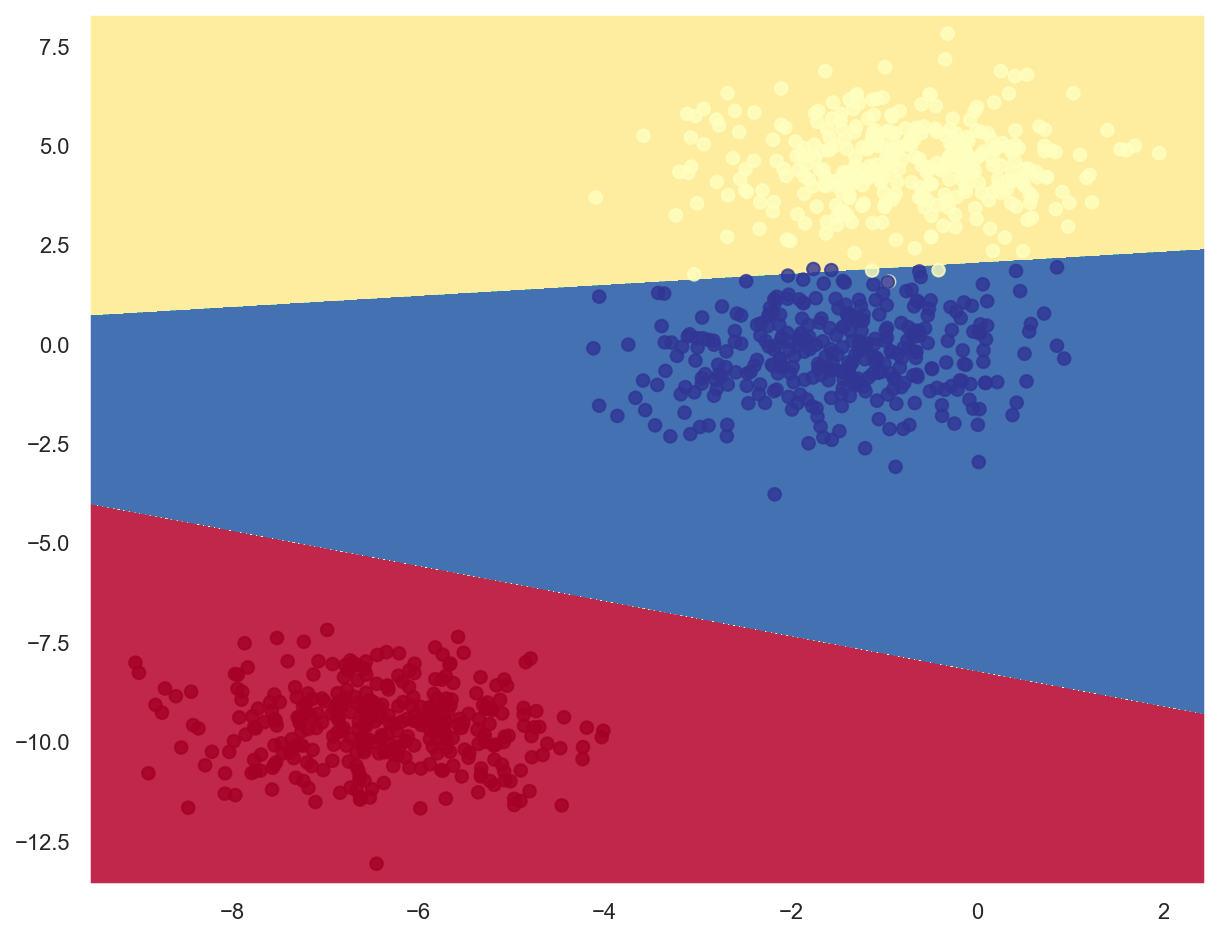

In [12]:
# Plot decision boundaries
plot_decision_boundary(lambda x: lr_model_multi.predict(x), x_train_multi, y_train_multi)

<h1>Titanic Disaster Survival Using Logistic Regression</h1>

In [1]:
#import libraries

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Load the Data**

In [2]:
#load data

In [28]:
titanic_data=pd.read_csv('titanic_train.csv')

In [29]:
len(titanic_data)

891

**View the data using head function which returns top  rows**

In [30]:
titanic_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [31]:
titanic_data.index

RangeIndex(start=0, stop=891, step=1)

In [32]:
titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [34]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [35]:
titanic_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [36]:
titanic_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

**Explaining Dataset**

survival : Survival 0 = No, 1 = Yes <br>
pclass : Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd <br>
sex : Sex <br>
Age : Age in years <br>
sibsp : Number of siblings / spouses aboard the Titanic 
<br>parch # of parents / children aboard the Titanic <br>
ticket : Ticket number fare Passenger fare cabin Cabin number <br>
embarked : Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton <br>




Data Analysis

Import Seaborn for visually analysing the data， Find out how many survived vs Died using countplot method of seaboarn

In [3]:
#countplot of subrvived vs not  survived

<AxesSubplot:xlabel='Survived', ylabel='count'>

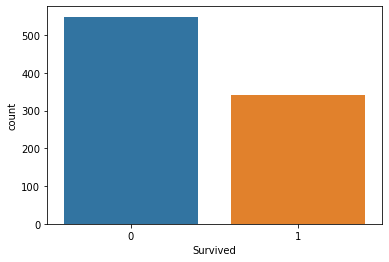

In [37]:
sns.countplot(x='Survived',data=titanic_data)

**Male vs Female Survival**

In [4]:
#Male vs Female Survived?

<AxesSubplot:xlabel='Survived', ylabel='count'>

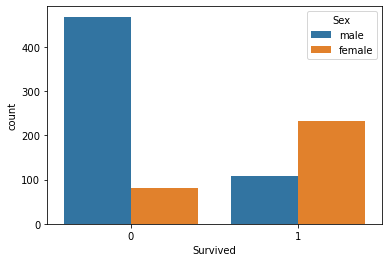

In [38]:
sns.countplot(x='Survived',data=titanic_data,hue='Sex')

**See age group of passengeres travelled **<br>
Note: We will use displot method to see the histogram. However some records does not have age hence the method will throw an error. In order to avoid that we will use dropna method to eliminate null values from graph

In [5]:
#Check for null

In [39]:
titanic_data.isna()

PassengerId  Survived  Pclass   Name    Sex    Age  SibSp  Parch  Ticket  \
0          False     False   False  False  False  False  False  False   False   
1          False     False   False  False  False  False  False  False   False   
2          False     False   False  False  False  False  False  False   False   
3          False     False   False  False  False  False  False  False   False   
4          False     False   False  False  False  False  False  False   False   
..           ...       ...     ...    ...    ...    ...    ...    ...     ...   
886        False     False   False  False  False  False  False  False   False   
887        False     False   False  False  False  False  False  False   False   
888        False     False   False  False  False   True  False  False   False   
889        False     False   False  False  False  False  False  False   False   
890        False     False   False  False  False  False  False  False   False   

      Fare  Cabin  Embarked  
0    False   True     False  
1    False  False     False  
2    False   True     False  
3    False  False     False  
4    False   True     False  
..     ...    ...       ...  
886  False   True     False  
887  False  False     False  
888  False   True     False  
889  False  False     False  
890  False   True     False  

[891 rows x 12 columns]

In [6]:
#Check how many values are null

In [40]:
titanic_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
#Visualize null values

<AxesSubplot:>

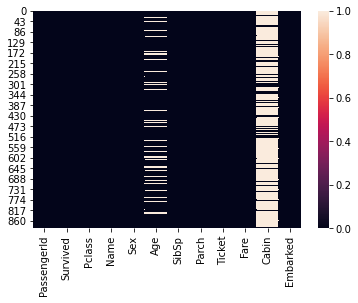

In [41]:
sns.heatmap(titanic_data.isna())

In [8]:
#find the % of null values in age column

In [46]:
(titanic_data['Age'].isna().sum()/len(titanic_data['Age']))*100

19.865319865319865

In [9]:
#find the % of null values in cabin column

In [47]:
(titanic_data['Cabin'].isna().sum()/len(titanic_data['Cabin']))*100

77.10437710437711

In [10]:
#find the distribution for the age column

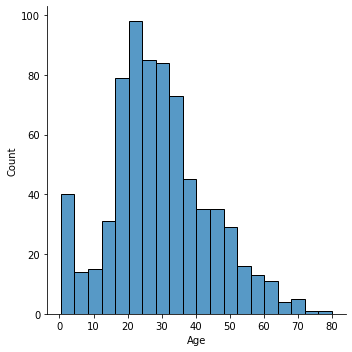

In [48]:
sns.displot(x='Age',data=titanic_data)

Data Cleaning

**Fill the missing values**<br> we will fill the missing values for age. In order to fill missing values we use fillna method.<br> For now we will fill the missing age by taking average of all age 

In [11]:
#fill age column

In [51]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(),inplace=True)

**We can verify that no more null data exist** <br> we will examine data by isnull mehtod which will return nothing

In [12]:
#verify null value

In [52]:
titanic_data['Age'].isna().sum()

0

**Alternatively we will visualise the null value using heatmap**<br>
we will use heatmap method by passing only records which are null. 

In [13]:
#visualize null values

<AxesSubplot:>

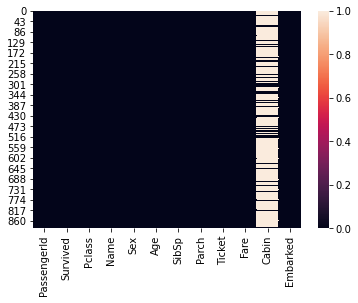

In [54]:
sns.heatmap(titanic_data.isna())

**We can see cabin column has a number of null values, as such we can not use it for prediction. Hence we will drop it**

In [14]:
#Drop cabin column

In [55]:
titanic_data.drop('Cabin',axis=1,inplace=True)

In [15]:
#see the contents of the data

In [56]:
titanic_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  
0      0         A/5 21171   7.2500        S  
1      0          PC 17599  71.2833        C  
2      0  STON/O2. 3101282   7.9250        S  
3      0            113803  53.1000        S  
4      0            373450   8.0500        S

**Preaparing Data for Model**<br>
No we will require to convert all non-numerical columns to numeric. Please note this is required for feeding data into model. Lets see which columns are non numeric info describe method

In [16]:
#Check for the non-numeric column

In [57]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [58]:
titanic_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

**We can see, Name, Sex, Ticket and Embarked are non-numerical.It seems Name,Embarked and Ticket number are not useful for Machine Learning Prediction hence we will eventually drop it. For Now we would convert Sex Column to dummies numerical values******

In [17]:
#convert sex column to numerical values

In [61]:
gender=pd.get_dummies(titanic_data['Sex'],drop_first=True)

In [62]:
titanic_data['Gender']=gender

In [64]:
titanic_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  Gender  
0      0         A/5 21171   7.2500        S       1  
1      0          PC 17599  71.2833        C       0  
2      0  STON/O2. 3101282   7.9250        S       0  
3      0            113803  53.1000        S       0  
4      0            373450   8.0500        S       1

In [18]:
#drop the columns which are not required

In [65]:
titanic_data.drop(['Name','Sex','Ticket','Embarked'],axis=1,inplace=True)

In [66]:
titanic_data.head()

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Gender
0            1         0       3  22.0      1      0   7.2500       1
1            2         1       1  38.0      1      0  71.2833       0
2            3         1       3  26.0      0      0   7.9250       0
3            4         1       1  35.0      1      0  53.1000       0
4            5         0       3  35.0      0      0   8.0500       1

In [19]:
#Seperate Dependent and Independent variables

In [67]:
x=titanic_data[['PassengerId','Pclass','Age','SibSp','Parch','Fare','Gender']]
y=titanic_data['Survived']

In [69]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

Data Modelling

**Building Model using Logestic Regression**

**Build the model**

In [20]:
#import train test split method

In [70]:
from sklearn.model_selection import train_test_split

In [21]:
#train test split

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [22]:
#import Logistic  Regression

In [72]:
from sklearn.linear_model import LogisticRegression

In [23]:
#Fit  Logistic Regression 

In [73]:
lr=LogisticRegression()

In [74]:
lr.fit(x_train,y_train)

C:\Users\gggg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
#predict

In [75]:
predict=lr.predict(x_test)

Testing

**See how our model is performing**

In [25]:
#print confusion matrix 

In [76]:
from sklearn.metrics import confusion_matrix

In [79]:
pd.DataFrame(confusion_matrix(y_test,predict),columns=['Predicted No','Predicted Yes'],index=['Actual No','Actual Yes'])

Predicted No  Predicted Yes
Actual No            151             24
Actual Yes            37             83

In [26]:
#import classification report

In [81]:
from sklearn.metrics import classification_report

In [82]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       175
           1       0.78      0.69      0.73       120

    accuracy                           0.79       295
   macro avg       0.79      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



**Precision is fine considering Model Selected and Available Data. Accuracy can be increased by further using more features (which we dropped earlier) and/or  by using other model**

Note: <br>
Precision : Precision is the ratio of correctly predicted positive observations to the total predicted positive observations <br>
Recall : Recall is the ratio of correctly predicted positive observations to the all observations in actual class
F1 score - F1 Score is the weighted average of Precision and Recall.

